In [14]:
import os, time, json, hashlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# -----------------------
# CONFIG
# -----------------------
DATA_DIR = Path(r"/home/phamtiendat/Documents/ComputerVision/Image_processing/Dataset_preprocessed")
OUTPUT_DIR = Path("weights_resnet50_head_custom")
IMG_SIZE = 224   # ResNet default
BATCH_SIZE = 32                  
NUM_EPOCHS = 50
LR = 1e-4
WARMUP_EPOCHS = 20
WEIGHT_DECAY = 1e-3    # L2 regularization applied via optimizer
NUM_WORKERS = 4
USE_AMP = True
MIXUP = False
SEED = 42
OUTPUT_DIR.mkdir(exist_ok=True)
print("DATA_DIR:", DATA_DIR)


DATA_DIR: /home/phamtiendat/Documents/ComputerVision/Image_processing/Dataset_preprocessed


In [15]:


# Device & reproducibility

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Dataset stats helpers

def print_dataset_stats(root):
    root = Path(root)
    for split in ("train","val","test"):
        s = root / split
        if not s.exists():
            print(f"{split} missing")
            continue
        total = 0
        print(f"\n--- {split} ---")
        for cls in sorted([p for p in s.iterdir() if p.is_dir()]):
            n = sum(1 for _ in cls.rglob("*") if _.is_file())
            total += n
            print(f"{cls.name:30s} {n:6d}")
        print("TOTAL", total)

def find_duplicates(root):
    root = Path(root)
    hashes = {}
    dups = []
    for split in ("train","val","test"):
        pdir = root / split
        if not pdir.exists(): continue
        for f in pdir.rglob("*"):
            if not f.is_file(): continue
            h = hashlib.sha256(f.read_bytes()).hexdigest()
            if h in hashes and hashes[h] != split:
                dups.append((hashes[h], split, f))
            else:
                hashes[h] = split
    return dups

print_dataset_stats(DATA_DIR)
dups = find_duplicates(DATA_DIR)
if dups:
    print("Duplicates across splits found (first 10):")
    for a,b,c in dups[:10]: print(a,b,c)
else:
    print("No exact duplicates found.")


Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU

--- train ---
Nail_psoriasis                   6164
SJS-TEN                          6459
Unknown_Normal                   2570
Vitiligo                         4113
acne                             2810
hyperpigmentation                1428
TOTAL 23544

--- val ---
Nail_psoriasis                    835
SJS-TEN                          1806
Unknown_Normal                    732
Vitiligo                         1134
acne                              374
hyperpigmentation                 390
TOTAL 5271

--- test ---
Nail_psoriasis                    291
SJS-TEN                           879
Unknown_Normal                    370
Vitiligo                          585
acne                              137
hyperpigmentation                 207
TOTAL 2469
Duplicates across splits found (first 10):
train val /home/phamtiendat/Documents/ComputerVision/Image_processing/Dataset_preprocessed/val/acne/padd-00_1000161__ProtectWyJQcm90ZWN0Il

In [16]:
# Data Augmentation
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.ColorJitter(0.2,0.2,0.2,0.05)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.01,0.05))
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


# Datasets & Dataloaders

train_ds = datasets.ImageFolder(str(DATA_DIR / "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(str(DATA_DIR / "val"),   transform=val_tf)
test_ds  = datasets.ImageFolder(str(DATA_DIR / "test"),  transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Classes:", train_ds.classes)
print("Counts:", len(train_ds), len(val_ds), len(test_ds))


Classes: ['Nail_psoriasis', 'SJS-TEN', 'Unknown_Normal', 'Vitiligo', 'acne', 'hyperpigmentation']
Counts: 23544 5271 2469


In [17]:

# Model: timm ResNet50 backbone + custom classification head

num_classes = len(train_ds.classes)

# Load backbone (pretrained) and then replace classifier with custom head.
backbone = timm.create_model("resnet50", pretrained=True)  # returns torchvision-like model with backbone+fc
in_f = backbone.fc.in_features

# Custom head : 2048 -> 512 -> 128 -> num_classes
# Activation = ELU, BatchNorm1d, Dropout 20%, L2 via optimizer weight_decay
custom_head = nn.Sequential(
    nn.Linear(in_f, 512),
    nn.ELU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.2),
    nn.Linear(512, 128),
    nn.ELU(inplace=True),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.2),
    nn.Linear(128, num_classes)
)

# Attach custom head
backbone.fc = custom_head
model = backbone.to(device)


# Loss / Optimizer / Scheduler / AMP

#criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 0.41
#criterion = nn.CrossEntropyLoss() #0.0 
criterion = nn.CrossEntropyLoss(label_smoothing=0.05) #

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
main_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - WARMUP_EPOCHS)

# 2. The warmup scheduler
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=WARMUP_EPOCHS)
scaler = torch.cuda.amp.GradScaler() if (USE_AMP and device.type=="cuda") else None


/tmp/ipykernel_5853/78932782.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (USE_AMP and device.type=="cuda") else None


In [18]:

# Train / Validate helpers

def mixup_data(x, y, alpha=0.2):
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_one_epoch(model, loader, optimizer, criterion, device, scaler, use_mixup=False, mixup_alpha=0.2):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            inputs, y_a, y_b, lam = mixup_data(inputs, labels, mixup_alpha)
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                outputs = model(inputs)
                loss = lam * criterion(outputs, y_a) + (1-lam) * criterion(outputs, y_b)
        else:
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        _, preds = torch.max(outputs, 1)
        bs = inputs.size(0)
        running_loss += loss.item() * bs
        # for mixup we compute running_corrects with respect to y_a for rough metric (not perfect)
        if not use_mixup:
            running_corrects += torch.sum(preds == labels).item()
        else:
            running_corrects += (lam * torch.sum(preds == y_a).item() + (1-lam) * torch.sum(preds == y_b).item())
        total += bs
    return running_loss/total, running_corrects/total

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.cuda.amp.autocast(enabled=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        bs = inputs.size(0)
        running_loss += loss.item() * bs
        running_corrects += torch.sum(preds == labels).item()
        total += bs
    return running_loss/total, running_corrects/total

In [19]:

# Training loop with checkpointing and history

history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
best_val = -1.0

for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, use_mixup=MIXUP, mixup_alpha=0.2)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)

    elapsed = time.time() - t0
    print(f"Epoch {epoch}/{NUM_EPOCHS} - train_loss {train_loss:.4f} train_acc {train_acc:.4f} | val_loss {val_loss:.4f} val_acc {val_acc:.4f} | time {elapsed:.1f}s")

    # save last (rich checkpoint)
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "val_acc": float(val_acc),
        "classes": train_ds.classes
    }, OUTPUT_DIR / "last.pth")

    # save best
    if val_acc > best_val + 1e-6:
        best_val = val_acc
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": float(val_acc),
            "classes": train_ds.classes
        }, OUTPUT_DIR / "best.pth")
        print(" -> saved best.pth")

    # scheduler step
    #scheduler.step()
    if epoch < WARMUP_EPOCHS:
        warmup_scheduler.step()
    else:
        main_scheduler.step()
        
   # current_lr = optimizer.param_groups[0]['lr']
    #print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Current LR: {current_lr}")
    torch.cuda.empty_cache()

print("Training finished. Best val:", best_val)

/tmp/ipykernel_5853/2037443089.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):
/tmp/ipykernel_5853/2037443089.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Epoch 1/50 - train_loss 1.7497 train_acc 0.2768 | val_loss 1.5847 val_acc 0.3961 | time 117.9s
 -> saved best.pth
Epoch 2/50 - train_loss 1.1761 train_acc 0.6219 | val_loss 0.9764 val_acc 0.7361 | time 117.7s
 -> saved best.pth
Epoch 3/50 - train_loss 0.7837 train_acc 0.8008 | val_loss 0.6536 val_acc 0.8541 | time 117.6s
 -> saved best.pth
Epoch 4/50 - train_loss 0.5883 train_acc 0.8794 | val_loss 0.4687 val_acc 0.9294 | time 117.7s
 -> saved best.pth
Epoch 5/50 - train_loss 0.4709 train_acc 0.9249 | val_loss 0.4011 val_acc 0.9518 | time 117.8s
 -> saved best.pth
Epoch 6/50 - train_loss 0.4035 train_acc 0.9534 | val_loss 0.3610 val_acc 0.9683 | time 117.8s
 -> saved best.pth
Epoch 7/50 - train_loss 0.3713 train_acc 0.9654 | val_loss 0.3339 val_acc 0.9769 | time 117.7s
 -> saved best.pth
Epoch 8/50 - train_loss 0.3463 train_acc 0.9749 | val_loss 0.3127 val_acc 0.9863 | time 117.6s
 -> saved best.pth
Epoch 9/50 - train_loss 0.3255 train_acc 0.9835 | val_loss 0.3036 val_acc 0.9905 | time 

KeyboardInterrupt: 

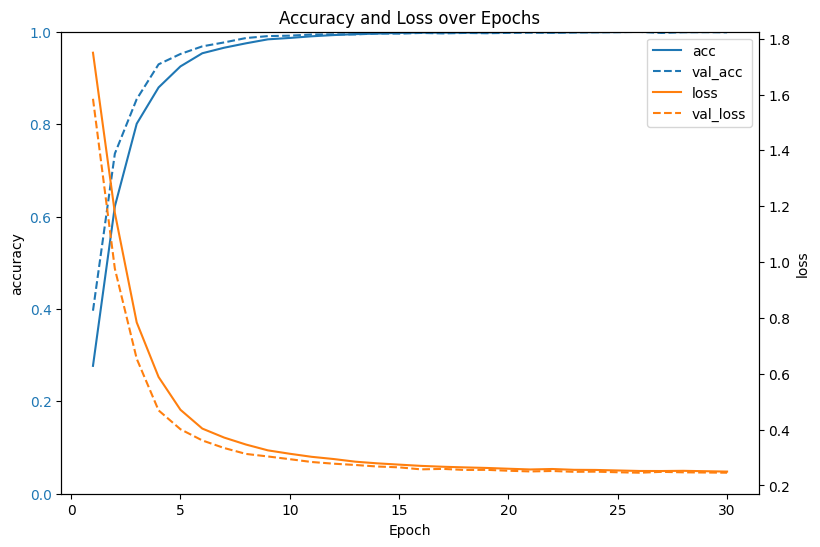

Loaded best.pth for further evaluation or export.


In [20]:
# -----------------------
# Plotting function (uses history)
# -----------------------
def plot_acc_loss(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, ax1 = plt.subplots(figsize=(9,6))
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("accuracy")
    ax1.plot(epochs, history["train_acc"], label="acc", linestyle="-", color="tab:blue")
    ax1.plot(epochs, history["val_acc"], label="val_acc", linestyle="--", color="tab:blue")
    ax1.set_ylim(0.0, 1.0)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel("loss")
    ax2.plot(epochs, history["train_loss"], label="loss", linestyle="-", color="tab:orange")
    ax2.plot(epochs, history["val_loss"], label="val_loss", linestyle="--", color="tab:orange")
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    plt.title("Accuracy and Loss over Epochs")
    plt.show()

# call plotting
plot_acc_loss(history)

# -----------------------
# (Optional) Load best model for evaluation/export
# -----------------------
ckpt = torch.load(OUTPUT_DIR / "best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"] if "model_state" in ckpt else ckpt)
model = model.to(device)
print("Loaded best.pth for further evaluation or export.")

                   precision    recall  f1-score   support

   Nail_psoriasis     1.0000    1.0000    1.0000       264
          SJS-TEN     0.9966    1.0000    0.9983       586
   Unknown_Normal     1.0000    1.0000    1.0000       185
         Vitiligo     0.9949    0.9949    0.9949       390
             acne     1.0000    1.0000    1.0000       123
hyperpigmentation     1.0000    0.9855    0.9927       138

         accuracy                         0.9976      1686
        macro avg     0.9986    0.9967    0.9976      1686
     weighted avg     0.9976    0.9976    0.9976      1686



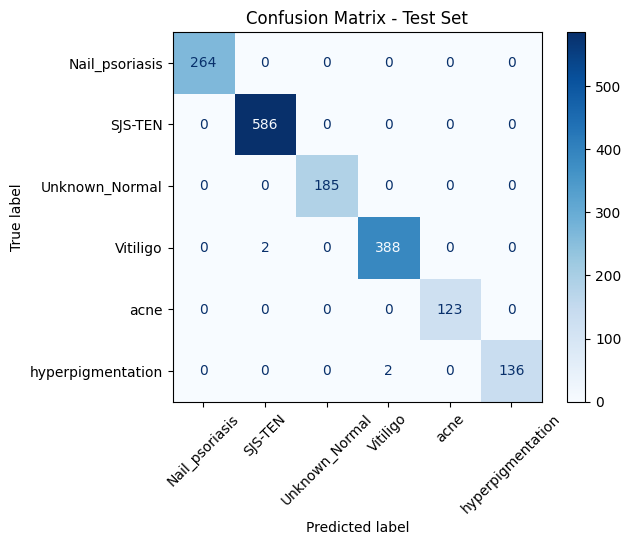

In [ ]:
# load best model
ckpt = torch.load(OUTPUT_DIR / "best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"] if "model_state" in ckpt else ckpt)  # support both dict formats
model = model.to(device)

def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix - Test Set")
    plt.show()

evaluate_model(model, test_loader, device, train_ds.classes)